In [1]:
import paddle.fluid as fluid
import paddle
import numpy as np
import os
import matplotlib.pyplot as plt

In [16]:
BUF_SIZE=500
BATCH_SIZE=20

#用于训练的数据提供器，每次从缓存中随机读取批次大小的数据
train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.train(), 
                          buf_size=BUF_SIZE),                    
    batch_size=BATCH_SIZE)   
#用于测试的数据提供器，每次从缓存中随机读取批次大小的数据
test_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.uci_housing.test(),
                          buf_size=BUF_SIZE),
    batch_size=BATCH_SIZE)  
    

In [4]:
#用于打印，查看uci_housing数据
train_data=paddle.dataset.uci_housing.train();
sampledata=next(train_data())
print(sampledata)

(array([-0.0405441 ,  0.06636364, -0.32356227, -0.06916996, -0.03435197,
        0.05563625, -0.03475696,  0.02682186, -0.37171335, -0.21419304,
       -0.33569506,  0.10143217, -0.21172912]), array([24.]))


In [3]:
#定义张量变量x，表示13维的特征值
x = fluid.layers.data(name='x', shape=[13], dtype='float32')
#定义张量y,表示目标值
y = fluid.layers.data(name='y', shape=[1], dtype='float32')
#定义一个两层全连接层的神经网络
#input:输入tensor;

hidden1 = fluid.layers.fc(input=x, size=100, act='sigmoid')  #第一层，神经元个数为100
hidden2 = fluid.layers.fc(input=hidden1, size=100, act='sigmoid')  #第二层，神经元个数为100
y_predict=fluid.layers.fc(input=hidden2,size=1,act=None)   #输出层，神经元个数为1

In [5]:
cost = fluid.layers.square_error_cost(input=y_predict, label=y) #求一个batch的损失值
avg_cost = fluid.layers.mean(cost)                              #对损失值求平均值

In [6]:
optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001)  #定义随机梯度下降法优化器
opts = optimizer.minimize(avg_cost)

In [7]:
test_program = fluid.default_main_program().clone(for_test=True)

In [8]:

use_cuda = False                         #use_cuda为False,表示运算场所为CPU;use_cuda为True,表示运算场所为GPU           
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
exe = fluid.Executor(place)              #创建一个Executor实例exe
exe.run(fluid.default_startup_program()) #Executor的run()方法执行startup_program(),进行参数初始化

[]

In [9]:
# 定义输入数据维度
feeder = fluid.DataFeeder(place=place, feed_list=[x, y])#feed_list:向模型输入的变量表或变量表名

In [11]:
#定义绘制训练过程的损失值变化趋势的方法draw_train_process
iter=0;
iters=[]
train_costs=[]

def draw_train_process(iters,train_costs):
    title="training cost"
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs,color='g',label='training cost') 
    plt.grid()
    plt.show()

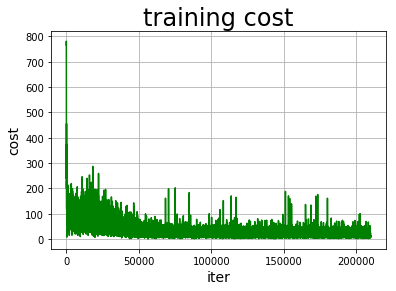

In [12]:
#训练并保存模型**
EPOCH_NUM=500
model_save_dir = "/home/aistudio/work/fit_a_line.inference.model"

for pass_id in range(EPOCH_NUM):                                  #训练EPOCH_NUM轮
    # 开始训练并输出最后一个batch的损失值
    train_cost = 0
    for batch_id, data in enumerate(train_reader()):              #遍历train_reader迭代器
        train_cost = exe.run(program=fluid.default_main_program(),#运行主程序
                             feed=feeder.feed(data),              #喂入一个batch的训练数据，根据feed_list和data提供的信息，将输入数据转成一种特殊的数据结构
                             fetch_list=[avg_cost])    
        if batch_id % 40 == 0:
            print("Pass:%d, Cost:%0.5f" % (pass_id, train_cost[0][0]))    #打印最后一个batch的损失值
        iter=iter+BATCH_SIZE
        iters.append(iter)
        train_costs.append(train_cost[0][0])
       
   
    # 开始测试并输出最后一个batch的损失值
    test_cost = 0
    for batch_id, data in enumerate(test_reader()):               #遍历test_reader迭代器
        test_cost= exe.run(program=test_program, #运行测试cheng
                            feed=feeder.feed(data),               #喂入一个batch的测试数据
                            fetch_list=[avg_cost])                #fetch均方误差
    print('Test:%d, Cost:%0.5f' % (pass_id, test_cost[0][0]))     #打印最后一个batch的损失值
    
    #保存模型
    # 如果保存路径不存在就创建
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
#保存训练参数到指定路径中，构建一个专门用预测的program
fluid.io.save_inference_model(model_save_dir,   #保存推理model的路径
                                  ['x'],            #推理（inference）需要 feed 的数据
                                  [y_predict],      #保存推理（inference）结果的 Variables
                                  exe)              #exe 保存 inference model
draw_train_process(iters,train_costs)

In [13]:
infer_exe = fluid.Executor(place)    #创建推测用的executor
inference_scope = fluid.core.Scope() #Scope指定作用域

**（2）可视化真实值与预测值方法定义**

In [14]:
#模型预测
infer_results=[]
groud_truths=[]

#绘制真实值和预测值对比图
def draw_infer_result(groud_truths,infer_results):
    title='Boston'
    plt.title(title, fontsize=24)
    x = np.arange(1,20) 
    y = x
    plt.plot(x, y)
    plt.xlabel('ground truth', fontsize=14)
    plt.ylabel('infer result', fontsize=14)
    plt.scatter(groud_truths, infer_results,color='b',label='training cost') 
    plt.grid()
    plt.show()

**(3)开始预测**

通过fluid.io.load_inference_model，预测器会从params_dirname中读取已经训练好的模型，来对从未遇见过的数据进行预测。

infer results: (House Price)
0: 10.49
1: 11.13
2: 11.16
3: 18.31
4: 12.46
5: 15.73
6: 14.25
7: 13.56
8: 8.42
9: 12.22
10: 7.53
11: 10.33
12: 11.74
13: 10.08
14: 10.05
15: 12.65
16: 17.58
17: 16.51
18: 16.75
19: 11.91
20: 13.20
21: 10.84
22: 14.20
23: 13.36
24: 12.82
25: 11.95
26: 14.98
27: 14.88
28: 18.33
29: 14.99
30: 14.58
31: 12.36
32: 13.24
33: 10.40
34: 9.08
35: 13.12
36: 13.01
37: 15.62
38: 17.14
39: 16.17
40: 11.99
41: 11.63
42: 15.91
43: 16.77
44: 16.06
45: 15.28
46: 14.17
47: 17.16
48: 16.87
49: 19.78
50: 13.46
51: 13.94
52: 12.46
53: 12.80
54: 15.84
55: 17.53
56: 16.81
57: 18.66
58: 18.59
59: 21.90
60: 19.10
61: 16.94
62: 13.38
63: 14.77
64: 15.52
65: 17.26
66: 18.08
67: 21.13
68: 20.29
69: 24.00
70: 15.09
71: 13.77
72: 17.65
73: 12.07
74: 16.79
75: 19.83
76: 22.35
77: 27.49
78: 29.84
79: 20.49
80: 18.35
81: 21.55
82: 18.15
83: 20.21
84: 13.43
85: 11.39
86: 9.79
87: 14.18
88: 16.12
89: 18.61
90: 18.24
91: 15.46
92: 13.67
93: 17.30
94: 18.85
95: 16.61
96: 17.99
97: 21.48
98: 2

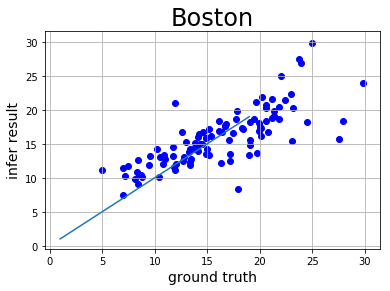

In [15]:
with fluid.scope_guard(inference_scope):#修改全局/默认作用域（scope）, 运行时中的所有变量都将分配给新的scope。
    #从指定目录中加载 推理model(inference model)
    [inference_program,                             #推理的program
     feed_target_names,                             #需要在推理program中提供数据的变量名称
     fetch_targets] = fluid.io.load_inference_model(#fetch_targets: 推断结果
                                    model_save_dir, #model_save_dir:模型训练路径 
                                    infer_exe)      #infer_exe: 预测用executor
    #获取预测数据
    infer_reader = paddle.batch(paddle.dataset.uci_housing.test(),  #获取uci_housing的测试数据
                          batch_size=200)                           #从测试数据中读取一个大小为200的batch数据
    #从test_reader中分割x
    test_data = next(infer_reader())
    test_x = np.array([data[0] for data in test_data]).astype("float32")
    test_y= np.array([data[1] for data in test_data]).astype("float32")
    results = infer_exe.run(inference_program,                              #预测模型
                            feed={feed_target_names[0]: np.array(test_x)},  #喂入要预测的x值
                            fetch_list=fetch_targets)                       #得到推测结果 
                            
    print("infer results: (House Price)")
    for idx, val in enumerate(results[0]):
        print("%d: %.2f" % (idx, val))
        infer_results.append(val)
    print("ground truth:")
    for idx, val in enumerate(test_y):
        print("%d: %.2f" % (idx, val))
        groud_truths.append(val)
    draw_infer_result(groud_truths,infer_results)